In [1]:
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
import torch, torchvision
print(torch.__version__)  # PyTorch version
print(torch.cuda.is_available())  # Check GPU availability
print(torch.cuda.get_device_name(0))  # Get GPU name

2.5.1
True
NVIDIA GeForce RTX 3050 Laptop GPU


<>:1: SyntaxWarning: invalid escape sequence '\o'
<>:1: SyntaxWarning: invalid escape sequence '\o'
C:\Users\ANJALI\AppData\Local\Temp\ipykernel_2248\2371043305.py:1: SyntaxWarning: invalid escape sequence '\o'
  img = Image.open('phone data\oil\Oil_0001.jpg')


device(type='cpu')

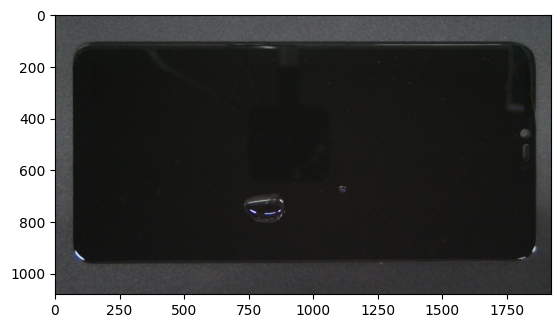

In [4]:
img = Image.open('phone data\oil\Oil_0001.jpg')
img = torchvision.transforms.ToTensor()(img)
plt.imshow(img.permute(1,2,0))
img.device

In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [7]:
transform = torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)),
                                            torchvision.transforms.ToTensor()])

dataset = ImageFolder(root='phone data', transform=transform)

# type(x), x.shape

# plt.imshow(x.permute(1,2,0))

train_dataset, test_dataset = torch.utils.data.random_split(dataset,[0.8,0.2])
print(len(train_dataset))
print(len(test_dataset))

train_dataloader = DataLoader(dataset=train_dataset,
                        batch_size=16,
                        num_workers=0,
                        shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                        batch_size=16,
                        num_workers=0,
                        shuffle=False)

960
240


MODEL TRAINING

In [9]:
cnnn_model = torchvision.models.mobilenet_v2(weights=True)

for param in cnnn_model.parameters():
    param.requires_grad=False

cnnn_model.classifier[1] = torch.nn.Linear(in_features=cnnn_model.classifier[1].in_features,
                                           out_features=len(dataset.classes))


c:\Users\ANJALI\.conda\envs\churn_analysis\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
#setup loss fuction and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=cnnn_model.parameters(), lr=0.001)
import torchmetrics
accuracy_score  = torchmetrics.Accuracy(task='multiclass', num_classes=len(dataset.classes)).to('cuda')

In [18]:
from tqdm.auto import tqdm

cnnn_model.to('cuda')
for epoch in tqdm(range(10)):

    running_train_loss=[]
    for x_train,y_train in train_dataloader:
        x_train=x_train.to('cuda')
        y_train=y_train.to('cuda')

        cnnn_model.train()

        y_pred = cnnn_model(x_train)

        loss = loss_fn(y_pred,y_train)
        running_train_loss.append(loss.item())

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

    if epoch % 2 ==0:
        cnnn_model.eval()
        running_test_loss=[]
        test_accuracy=[]

        for x_test,y_test in test_dataloader:
            x_test = x_test.to('cuda')
            y_test = y_test.to('cuda')
            
            with torch.no_grad():
                test_pred=cnnn_model(x_test)
            
            running_test_loss.append(loss_fn(test_pred,y_test).item())
            test_accuracy.append(accuracy_score(test_pred.softmax(dim=-1),y_test))
        print(f' train_loss: {sum(running_train_loss)/len(running_train_loss)} || test loss: {sum(running_test_loss)/len(running_test_loss)} || test acc: {sum(test_accuracy)/len(test_accuracy)} ')


  0%|          | 0/10 [00:00<?, ?it/s]

 train_loss: 0.18054542541503907 || test loss: 0.10285591731468836 || test acc: 0.9875000715255737 
 train_loss: 0.15166981338212887 || test loss: 0.0818123017748197 || test acc: 0.9791667461395264 
 train_loss: 0.09986603781580924 || test loss: 0.07198758348822594 || test acc: 0.98333340883255 
 train_loss: 0.11093312151109179 || test loss: 0.05696499117960532 || test acc: 0.98333340883255 
 train_loss: 0.08395701216844222 || test loss: 0.07219179440289736 || test acc: 0.9750000238418579 


SAVING THE TRAINED MODEL IN PYTORCH

In [20]:
torch.save(cnnn_model.state_dict(),'cnn_model_2.pth')


In [22]:
cnnn_model = torchvision.models.mobilenet_v2(weights=True)

for param in cnnn_model.parameters():
    param.requires_grad=False

cnnn_model.classifier[1] = torch.nn.Linear(in_features=cnnn_model.classifier[1].in_features,
                                           out_features=len(dataset.classes))

ww = torch.load('cnn_model_2.pth')
cnnn_model.load_state_dict(ww)

cnnn_model.to('cuda')
cnnn_model.eval()

c:\Users\ANJALI\.conda\envs\churn_analysis\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\ANJALI\AppData\Local\Temp\ipykernel_2248\905294145.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arb

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

VISUALIZING THE RESULTS

In [23]:
for x_test,y_test in test_dataloader:
    x_test,y_test = x_test.to('cuda'), y_test.to('cuda')

    with torch.no_grad():
        y_pred = cnnn_model(x_test)
    break    

In [30]:
from infer import predict_screen_defect

In [31]:
l,c = predict_screen_defect('phone data/oil/Oil_0001.jpg')

In [32]:
l,c

('oil', 0.9988096952438354)

In [24]:
y_test

tensor([1, 2, 1, 2, 0, 1, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2], device='cuda:0')

In [28]:
true_classes = [dataset.classes[yl] for yl in y_test]
predicted_classes = [dataset.classes[yl] for yl in y_pred.argmax(dim=1)]
confidence = [yl.max().item() for yl in y_pred.softmax(dim=1)]

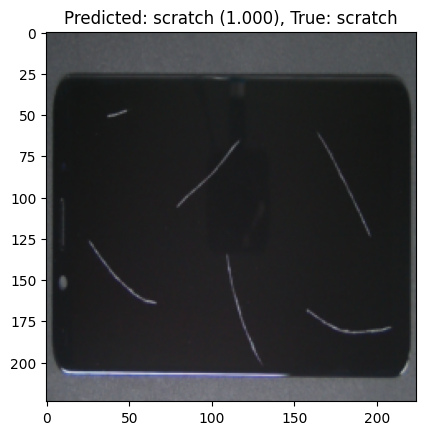

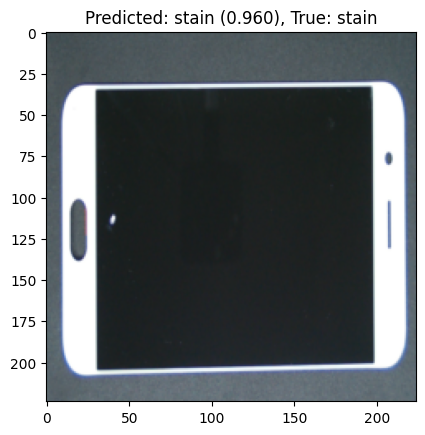

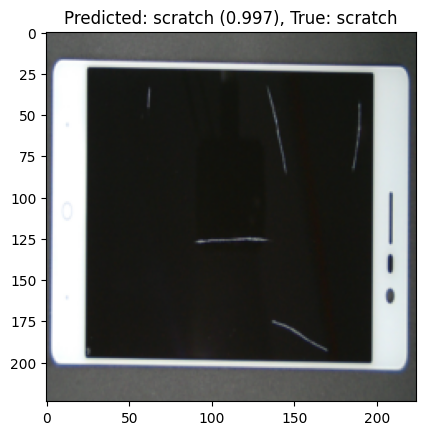

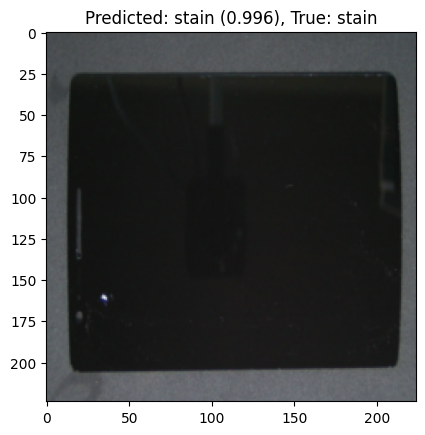

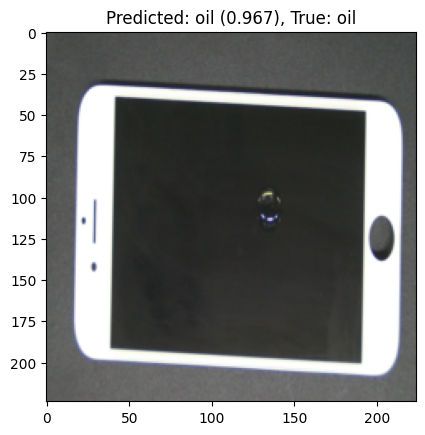

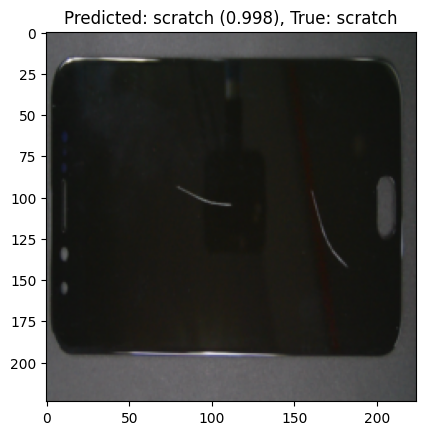

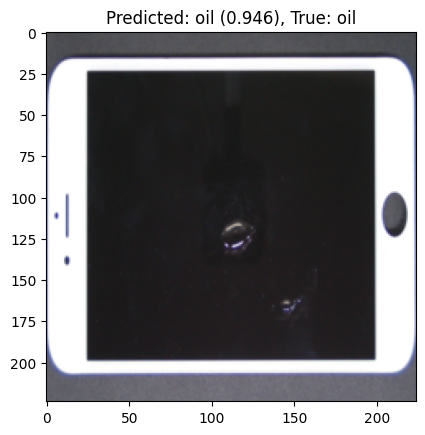

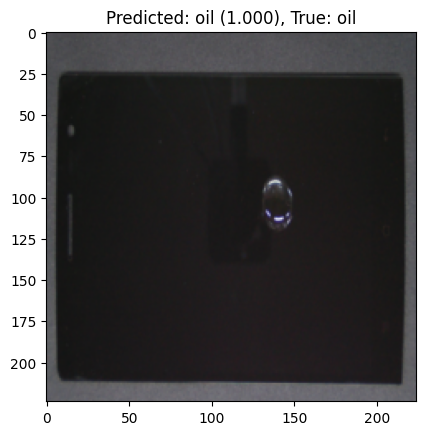

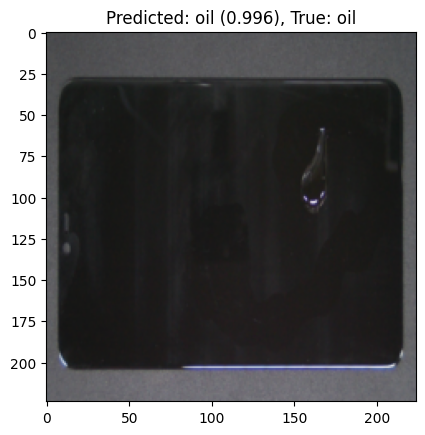

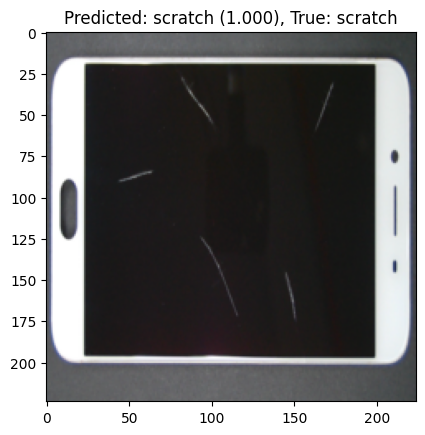

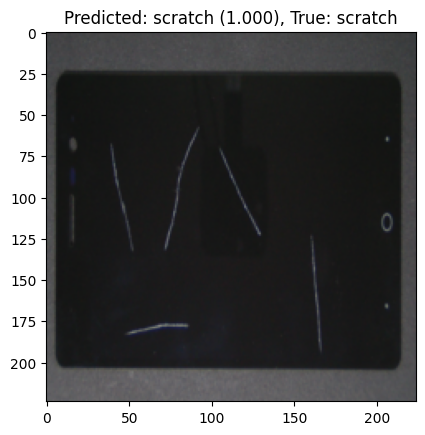

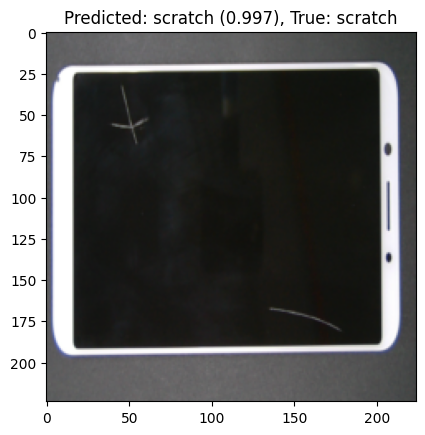

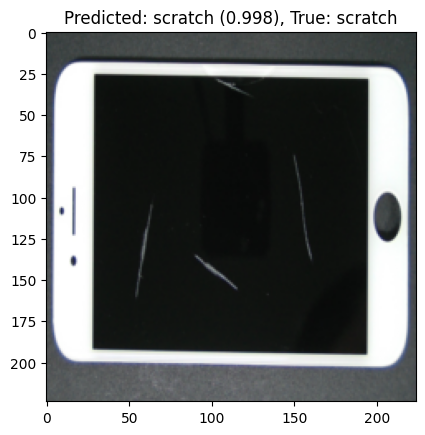

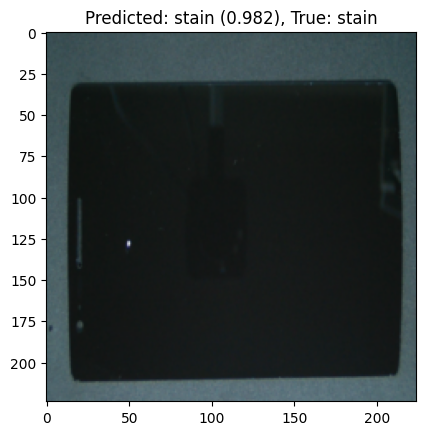

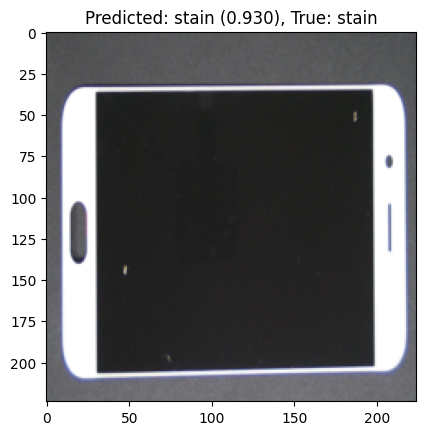

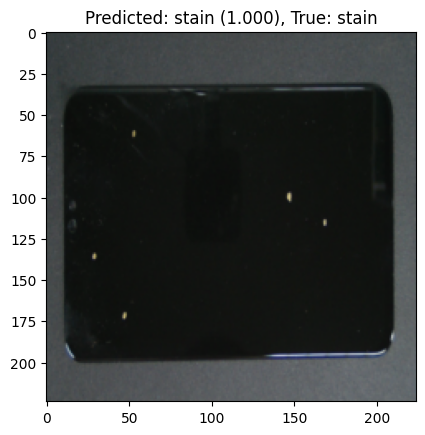

In [29]:
for idx,xx in enumerate(x_test):
    plt.imshow(xx.permute(1,2,0).cpu())
    plt.title(f'Predicted: {predicted_classes[idx]} ({confidence[idx]:.3f}), True: {true_classes[idx]}')
    plt.show()